In [125]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
from torch.utils.data import TensorDataset, DataLoader,random_split
from kernel import ARDKernel
import time
import torch.optim as optim
from model_FAQ.non_positive_definite_fixer import remove_similar_data
import GP_CommonCalculation as GP
JITTER=1e-3
torch.manual_seed(4)
#不能用lbfgs

In [126]:
class SVIGP(nn.Module):
    def __init__(self, X, Y, num_inducing,batchsize=None, normal_y_mode=0):
        super(SVIGP, self).__init__()
        self.data = GP.data_normalization(X, Y, normal_y_mode)
        #self.X_all, self.Y_all =X,Y
        self.X_all, self.Y_all = self.data.normalize(X, Y)
        self.X_all, self.Y_all = remove_similar_data(self.X_all, self.Y_all)
        self.batchsize = batchsize
        self.kernel=ARDKernel(1)
        self.num_inducing=num_inducing
        # Inducing points
        subset_indices = torch.randperm(self.X_all.size(0))[:self.num_inducing]
        self.xm = nn.Parameter(self.X_all[subset_indices])  # Inducing points
        self.qu_mean=nn.Parameter(self.Y_all[subset_indices])
        #self.xm = nn.Parameter(torch.rand(self.num_inducing,1)) 
        #self.qu_mean=nn.Parameter(torch.rand(self.num_inducing,1))
        self.chole=nn.Parameter(torch.rand(self.num_inducing,1))
        self.kernel=ARDKernel(1)
        self.log_beta=nn.Parameter(torch.ones(1) * 0)
        
        if self.batchsize is not None:
            # Create TensorDataset and DataLoader for minibatch training
            dataset = TensorDataset(self.X_all, self.Y_all)
            self.dataloader = DataLoader(dataset, batch_size=self.batchsize, shuffle=True)
            self.iterator = iter(self.dataloader)
        else:
            self.iterator = None
        
    def new_batch(self):
        if self.iterator is not None:
            try:
                X_batch, Y_batch = next(self.iterator)
            except StopIteration:
                # Reinitialize the iterator if it reaches the end
                self.iterator = iter(self.dataloader)
                X_batch, Y_batch = next(self.iterator)
            return X_batch, Y_batch
        else:
            return self.X_all, self.Y_all
    def variational_loss(self,X):
        K_mm=self.kernel(self.xm,self.xm)+JITTER*torch.eye(self.xm.size(0))
        Lm = torch.linalg.cholesky(K_mm)
        K_mm_inv= torch.cholesky_inverse(Lm)
        K_mn=self.kernel(self.xm,X)
        K_nm=K_mn.t()
        qu_S=self.chole@self.chole.t()+JITTER * torch.eye(self.xm.size(0)) #insure positive definite
        Ls=torch.linalg.cholesky(qu_S)
        K_nn=self.kernel(X,X).diag()
        
        #K_nm*K_mm_inv*m, (b,1)
        mean_vector=K_nm@K_mm_inv@self.qu_mean
        
        #diag(K_tilde), (b,1)
        precision = 1 / self.log_beta.exp()
        K_tilde=precision*(K_nn-(K_nm@K_mm_inv@K_mn).diag())
        
        # k_i \cdot k_i^T, (b, m, m)
        # Expand dimensions and transpose for batch
        K_nm_expanded = K_nm.unsqueeze(2)  # Shape (b, m, 1)
        K_nm_transposed = K_nm_expanded.transpose(1, 2)  # Shape (b, 1, m)
        
        # Perform batch matrix multiplication
        lambda_mat = torch.matmul(K_nm_expanded, K_nm_transposed)  # Shape (b, m, m)
        # K_mm_inv \cdot k_i \cdot k_i^T \cdot K_mm_inv, (b, m, m)
        lambda_mat=K_mm_inv@lambda_mat@K_mm_inv
        # Trace terms, (b,)
        batch_matrices =qu_S@lambda_mat
        traces = precision *torch.einsum('bii->b', batch_matrices)

        #Likelihood
        likelihood_sum=-0.5 * (torch.sum(K_tilde)+ torch.sum(traces))
        
        # compute KL
        logdetS = 2 * Ls.diag().abs().log().sum()
        logdetKmm=2*Lm.diag().abs().log().sum()
        KL =  0.5*(K_mm_inv@qu_S).diag().sum(dim = 0).view(-1,1)+ 0.5*(self.qu_mean.t()@K_mm_inv@self.qu_mean)\
        -0.5*logdetS+ 0.5*logdetKmm -0.5*self.num_inducing
        
        return likelihood_sum,KL,mean_vector

    def forward(self,Xte):
        K_mm=self.kernel(self.xm,self.xm)+JITTER*torch.eye(self.xm.size(0))
        Lm = torch.linalg.cholesky(K_mm)
        K_mm_inv= torch.cholesky_inverse(Lm)
        K_tt=self.kernel(Xte,Xte)
        K_tm=self.kernel(Xte,self.xm)
        A=K_tm@K_mm_inv #(t,m)
        mean=A@self.qu_mean #(t,1)
        #mean= self.data.denormalize_result(mean)
        return mean

In [127]:
torch.manual_seed(4)
#train_set
num_data=200
xtr = torch.rand(num_data, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(num_data, 1) * 0.1

#test_set
xte = torch.linspace(0, 1, 1000).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

tensor([[658.4731]], grad_fn=<SubBackward0>)
tensor([[656.1580]], grad_fn=<SubBackward0>)
tensor([[652.1496]], grad_fn=<SubBackward0>)
tensor([[644.5933]], grad_fn=<SubBackward0>)
tensor([[635.2938]], grad_fn=<SubBackward0>)
tensor([[628.4658]], grad_fn=<SubBackward0>)
tensor([[614.7618]], grad_fn=<SubBackward0>)
tensor([[605.2379]], grad_fn=<SubBackward0>)
tensor([[593.1711]], grad_fn=<SubBackward0>)
tensor([[580.9930]], grad_fn=<SubBackward0>)
tensor([[567.2762]], grad_fn=<SubBackward0>)
tensor([[558.0578]], grad_fn=<SubBackward0>)
tensor([[532.4294]], grad_fn=<SubBackward0>)
tensor([[524.0790]], grad_fn=<SubBackward0>)
tensor([[509.0367]], grad_fn=<SubBackward0>)
tensor([[496.1375]], grad_fn=<SubBackward0>)
tensor([[481.0724]], grad_fn=<SubBackward0>)
tensor([[471.7229]], grad_fn=<SubBackward0>)
tensor([[458.0518]], grad_fn=<SubBackward0>)
tensor([[449.3612]], grad_fn=<SubBackward0>)
tensor([[430.7280]], grad_fn=<SubBackward0>)
tensor([[420.6461]], grad_fn=<SubBackward0>)
tensor([[3

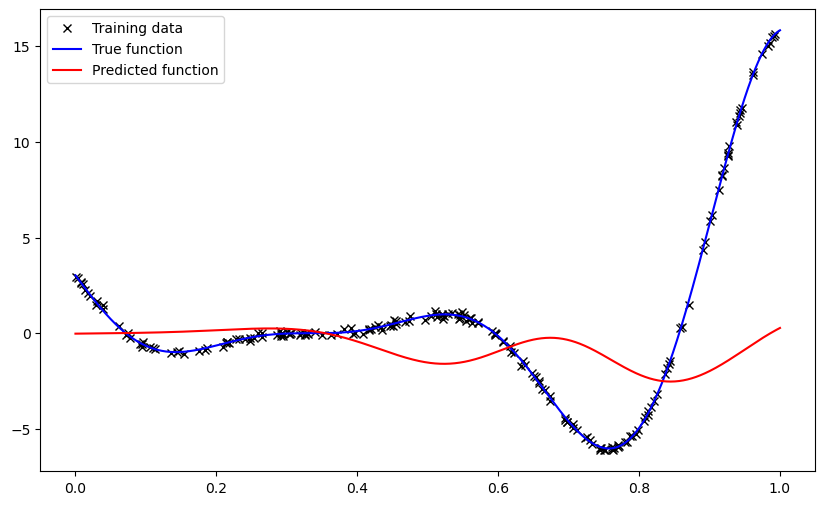

In [128]:
torch.manual_seed(4)
# Training the model
num_inducing = 20
batch_size =200
learning_rate = 0.01
num_epochs = 100

# Create an instance of SVIGP
model = SVIGP(xtr, ytr, num_inducing=num_inducing, batchsize=batch_size)
#plt.plot(model.xm.detach().numpy(), model.qu_mean.detach().numpy(), 'kx', label='Training data')
optimizer = optim.LBFGS(model.parameters(), lr=learning_rate, max_iter=300)

# Training loop

    
def closure():
    optimizer.zero_grad()
    X_batch, Y_batch = model.new_batch()
    likelihood, KL, _ = model.variational_loss(X_batch)
    #print(likelihood, KL)
    loss = KL-likelihood*num_data /batch_size  # Negative ELBO
    loss.backward()
    print(loss)
    #print(model.qu_mean)
    #print(f'Gradient of qu_mean before step: {model.qu_mean.grad}')
    return loss

optimizer.step(closure)

    

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(xte)
    mse = torch.mean((predictions - yte) ** 2)
    print(f'Test MSE: {mse.item()}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(xtr.numpy(), ytr.numpy(), 'kx', label='Training data')
plt.plot(xte.numpy(), yte.numpy(), 'b', label='True function')
plt.plot(xte.numpy(), predictions.numpy(), 'r', label='Predicted function')
plt.legend()
plt.show()

Test MSE: 15.064874649047852


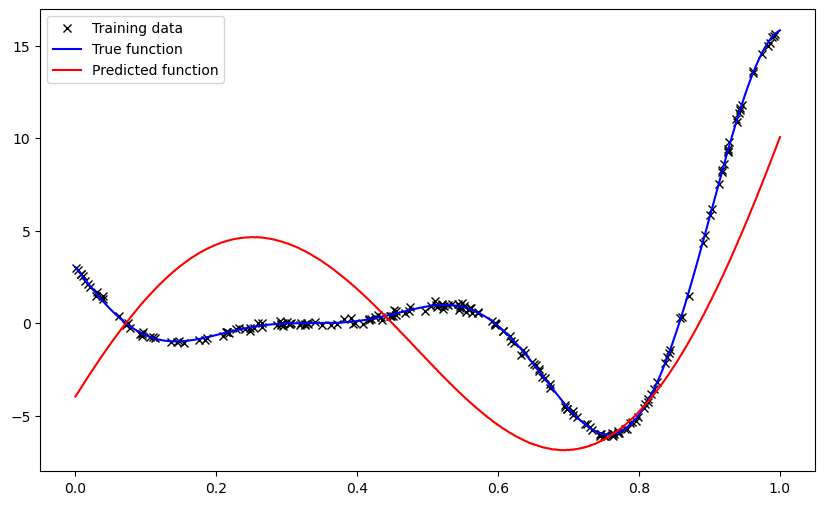

In [121]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(xte)
    mse = torch.mean((predictions - yte) ** 2)
    print(f'Test MSE: {mse.item()}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(xtr.numpy(), ytr.numpy(), 'kx', label='Training data')
plt.plot(xte.numpy(), yte.numpy(), 'b', label='True function')
plt.plot(xte.numpy(), predictions.numpy(), 'r', label='Predicted function')
plt.legend()
plt.show()